In [1]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from PIL.Image import Image as PilImage
import textwrap, os

In [2]:
transform = T.ToPILImage()

In [3]:
print("Running on: ")
if torch.cuda.is_available(): 
    dev = "cuda:0"
    print("Cuda")
else:
    dev = "cpu"
    print("CPU")
device = torch.device(dev) 
a = torch.zeros(4,3) 
a = a.to(device)

Running on: 
CPU


In [4]:
size = 28

In [5]:
def load_digits(folder, has_labels = True):
    df = pd.read_csv(folder)
    labels = torch.tensor(df["label"].values).to(device) if has_labels else None
    data = torch.tensor(df.loc[:, df.columns != 'label'].values / 256).float()
    data = data.view(data.shape[0],1, size, size)
    data = data.to(device)
    return data, labels

In [6]:
data, labels = load_digits('/kaggle/input/digit-recognizer/train.csv')

In [7]:
test_data, test_labels = load_digits('/kaggle/input/digit-recognizer/test.csv', has_labels = False)

In [8]:
def image_grid(
    data,
    labels
):
    images = [transform(i[0]) for i in data]
    str_labels = [str(i.item()) for i in labels]
    plt.figure()
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / 5)+1, 5, i +1)
        plt.imshow(image)
        plt.title(str_labels[i], fontsize=16); 

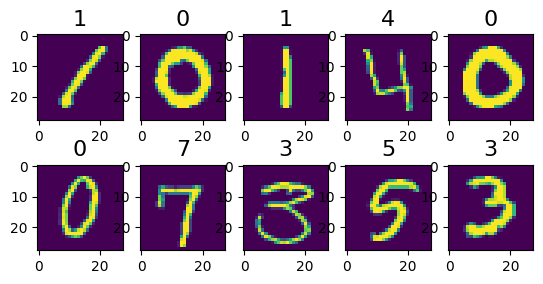

In [9]:
image_grid(data[0:10], labels[0:10])

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.block1 = nn.Sequential(
            nn.LazyConv2d(20, kernel_size=5),
            nn.Dropout(),
            nn.LazyConv2d(10, kernel_size=5),
            nn.LazyBatchNorm2d()
        )
        self.block2 = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(400),
            nn.GELU(),
            nn.Dropout(),
            nn.LazyLinear(10),
            nn.LogSoftmax(dim = 1)
        )
    
    def forward(self, x):
        out = x
        out = self.block1(out)
        out = self.block2(out)
        return out


In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

In [12]:
n_epochs = 40
batch_size_train = 8
learning_rate = 3e-4
momentum = 0.8
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [13]:
network = Net()
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [14]:
train_loader = DataLoader(torch.utils.data.TensorDataset(data, labels), batch_size=batch_size_train, shuffle=True)

In [15]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [16]:


def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()
            ))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset))
            )
            torch.save(network.state_dict(), '/kaggle/working/model.pth')
            torch.save(optimizer.state_dict(), '/kaggle/working/optimizer.pth')
            

In [17]:
for epoch in range(1,n_epochs+1):
    train(epoch)

Train Epoch: 1 [0/42000 (0%)]	Loss: 2.204502
Train Epoch: 1 [800/42000 (2%)]	Loss: 0.630398
Train Epoch: 1 [1600/42000 (4%)]	Loss: 1.379140
Train Epoch: 1 [2400/42000 (6%)]	Loss: 0.146076
Train Epoch: 1 [3200/42000 (8%)]	Loss: 0.229314
Train Epoch: 1 [4000/42000 (10%)]	Loss: 0.186235
Train Epoch: 1 [4800/42000 (11%)]	Loss: 0.019224
Train Epoch: 1 [5600/42000 (13%)]	Loss: 0.142999
Train Epoch: 1 [6400/42000 (15%)]	Loss: 2.607169
Train Epoch: 1 [7200/42000 (17%)]	Loss: 0.052973
Train Epoch: 1 [8000/42000 (19%)]	Loss: 0.118285
Train Epoch: 1 [8800/42000 (21%)]	Loss: 0.055054
Train Epoch: 1 [9600/42000 (23%)]	Loss: 0.271746
Train Epoch: 1 [10400/42000 (25%)]	Loss: 0.167700
Train Epoch: 1 [11200/42000 (27%)]	Loss: 0.368588
Train Epoch: 1 [12000/42000 (29%)]	Loss: 0.134112
Train Epoch: 1 [12800/42000 (30%)]	Loss: 0.234701
Train Epoch: 1 [13600/42000 (32%)]	Loss: 0.941403
Train Epoch: 1 [14400/42000 (34%)]	Loss: 0.140469
Train Epoch: 1 [15200/42000 (36%)]	Loss: 0.115019
Train Epoch: 1 [16000/

Text(0, 0.5, 'negative log likelihood loss')

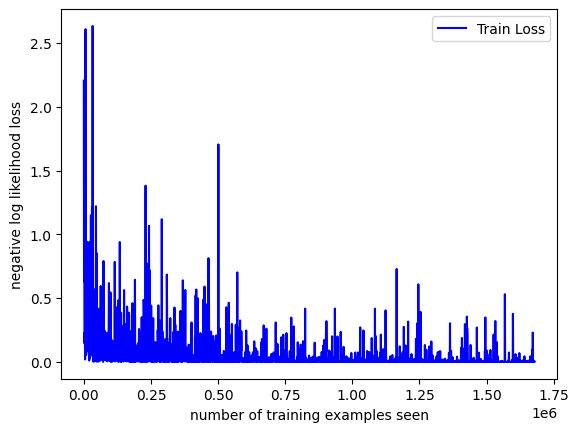

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [19]:
test_labels = [torch.argmax(d) for d in network(test_data)]

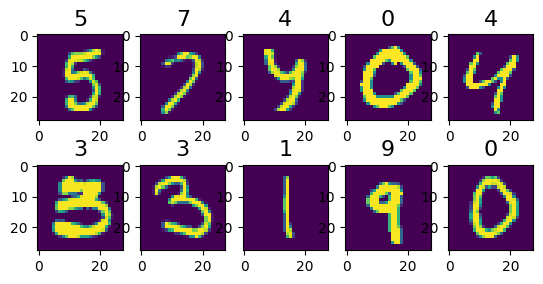

In [20]:
image_grid(test_data[10:20], test_labels[10:20])

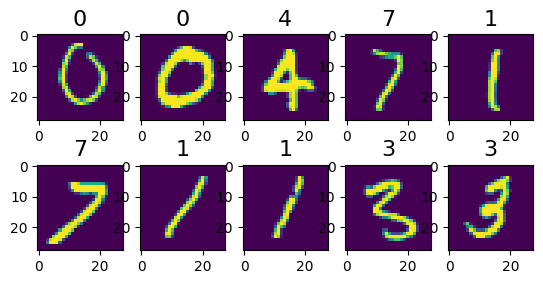

In [21]:
image_grid(test_data[110:120], test_labels[110:120])

In [22]:
result = pd.DataFrame([l.cpu().item() for idx, l in enumerate(test_labels)], columns=['label'])
result.index += 1
result.to_csv('/kaggle/working/kaggle_img_rec_result.csv', index_label='ImageId')